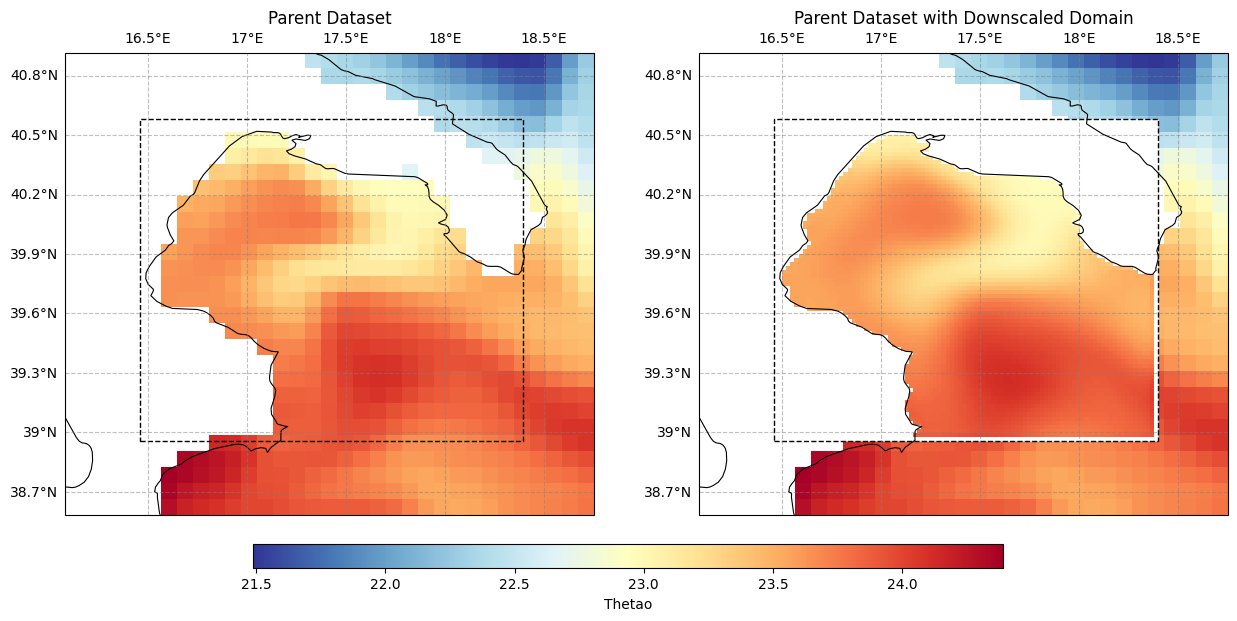

In [25]:
import logging
import os
import numpy as np
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from cartopy.io import DownloadWarning
from matplotlib.patches import Rectangle

# Suppress warnings (optional)
warnings.filterwarnings("ignore", category=DownloadWarning)

# Dataset parameters
datasets = {
    'downscaled': {
        'src_path': "/Users/lgiunti/Work/Tests/test-surf-nemo/gulfTaranto_20141005_DEMONSTRATOR/nest_0/simulation/2014-10-06T00-00-00_2014-10-07T00-00-00",
        'src_filename': "output_fields_grid_T.nc",
        'mask_path': "/Users/lgiunti/Work/Tests/test-surf-nemo/gulfTaranto_20141005_DEMONSTRATOR/nest_0/preprocessing/meshing/mesh/output/",
        'mask_filename': "mesh_mask.nc",
        'mask_var_name': "tmask",
        'var_name': "thetao",
        'lat_coord_name': "nav_lat",
        'lon_coord_name': "nav_lon",
    },
    'parent': {
        'src_path': "/Users/lgiunti/Work/Tests/test-surf-nemo/gulfTaranto_20141005_DEMONSTRATOR/nest_0/preprocessing/ocean_obc/reformat/",
        'src_filename': "tem_y2014m10d06.nc",
        'mask_path': "/Users/lgiunti/Work/Tests/test-surf-nemo/gulfTaranto_20141005_DEMONSTRATOR/nest_0/preprocessing/ocean_obc/reformat/",
        'mask_filename': "mask_ocean_T.nc",
        'mask_var_name': "tmask",
        'var_name': "thetao",
        'lat_coord_name': "nav_lat",
        'lon_coord_name': "nav_lon",
    },
}

# General parameters
dst_path = "."
t_slice = ""
z_slice = ""
export_to_pdf = False
figsize = (15, 8)
enable_contour_plot = True

# Set defaults
imshow_kwargs = {"cmap": "RdYlBu_r", "origin": "lower"}
contour_kwargs = {"cmap": "RdYlBu_r", "nlevels": 15}
colorbar_kwargs = {"orientation": "vertical", "pad": 0.025}
coastline_kwargs = {"linewidth": 0.8, "color": "k"}
gridlines_kwargs = {"draw_labels": True, "color": "gray", "alpha": 0.5, "linestyle": "--"}

def read_and_process_dataset(params, t_slice="", z_slice=""):
    ds = xr.open_dataset(os.path.join(params['src_path'], params['src_filename']))
    ds_mask = xr.open_dataset(os.path.join(params['mask_path'], params['mask_filename']))

    lon = ds[params['lon_coord_name']].values
    lat = ds[params['lat_coord_name']].values

    # Handle 'zos' variable if needed
    if params['var_name'] == "zos":
        ds[params['var_name']] = ds[params['var_name']].expand_dims("z", 1)
        z_slice = "0-1"

    shape = ds[params['var_name']].shape
    t_slice = t_slice.split("-") if t_slice != "" else [0, shape[0]]
    z_slice = z_slice.split("-") if z_slice != "" else [0, shape[1]]

    t = int(t_slice[0])
    z = int(z_slice[0])

    # Get data and mask
    data = ds[params['var_name']][t, z, ...].values
    mask = ds_mask[params['mask_var_name']][0, z, ...].values
    data_masked = xr.where(mask == 0, np.nan, data)

    # Ensure lon and lat are 2D if needed
    if lon.ndim == 1 and lat.ndim == 1:
        lon2d, lat2d = np.meshgrid(lon, lat)
    else:
        lon2d = lon
        lat2d = lat

    return lon2d, lat2d, data_masked

# Read and process datasets
lon_downscaled, lat_downscaled, data_masked_downscaled = read_and_process_dataset(datasets['downscaled'], t_slice, z_slice)
lon_parent, lat_parent, data_masked_parent = read_and_process_dataset(datasets['parent'], t_slice, z_slice)

# Determine the common color scale
vmin = np.nanmin([np.nanmin(data_masked_downscaled), np.nanmin(data_masked_parent)])
vmax = np.nanmax([np.nanmax(data_masked_downscaled), np.nanmax(data_masked_parent)])

# Create figure and subplots using plt.subplots
fig, (ax_parent, ax_combined) = plt.subplots(nrows=1, ncols=2, figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})

# Parent dataset: Left subplot (ax_parent)
extent_parent = [lon_parent.min(), lon_parent.max(), lat_parent.min(), lat_parent.max()]
ax_parent.set_extent(extent_parent, crs=ccrs.PlateCarree())

# Plot parent dataset on ax_parent
im_parent = ax_parent.imshow(data_masked_parent, extent=extent_parent, vmin=vmin, vmax=vmax, **imshow_kwargs)
ax_parent.coastlines(**coastline_kwargs)
gl_parent = ax_parent.gridlines(crs=ccrs.PlateCarree(), **gridlines_kwargs)
gl_parent.right_labels = False
gl_parent.bottom_labels = False

# Overlay downscaled extent as dashed rectangle on ax_parent
extent_downscaled = [lon_downscaled.min(), lon_downscaled.max(), lat_downscaled.min(), lat_downscaled.max()]
rect = Rectangle((extent_downscaled[0], extent_downscaled[2]),
                 extent_downscaled[1]-extent_downscaled[0],
                 extent_downscaled[3]-extent_downscaled[2],
                 linewidth=1, edgecolor='k', facecolor='none', linestyle='--', transform=ccrs.PlateCarree())
ax_parent.add_patch(rect)

# Combined plot: Right subplot (ax_combined)
ax_combined.set_extent(extent_parent, crs=ccrs.PlateCarree())

# Plot parent dataset on ax_combined
im_combined = ax_combined.imshow(data_masked_parent, zorder=0, extent=extent_parent, vmin=vmin, vmax=vmax, **imshow_kwargs)

# Add the dashed rectangle to ax_combined
rect2 = Rectangle((extent_downscaled[0], extent_downscaled[2]),
                  extent_downscaled[1]-extent_downscaled[0],
                  extent_downscaled[3]-extent_downscaled[2],
                  linewidth=1, edgecolor='k', zorder=1, facecolor='white', linestyle='--', transform=ccrs.PlateCarree())
ax_combined.add_patch(rect2)

# Overlay downscaled data onto ax_combined within the rectangle
ax_combined.imshow(data_masked_downscaled, zorder=2, extent=extent_downscaled, vmin=vmin, vmax=vmax, **imshow_kwargs)

ax_combined.coastlines(zorder=3, **coastline_kwargs)
gl_combined = ax_combined.gridlines(crs=ccrs.PlateCarree(), zorder=4, **gridlines_kwargs)
gl_combined.right_labels = False
gl_combined.bottom_labels = False

# Add titles
ax_parent.set_title("Parent Dataset")
ax_combined.set_title("Parent Dataset with Downscaled Domain")

# Add shared colorbar
cbar_ax = fig.add_axes([0.25, 0.14, 0.5, 0.03])  # Adjust position and size as needed
cbar = plt.colorbar(im_parent, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Thetao')



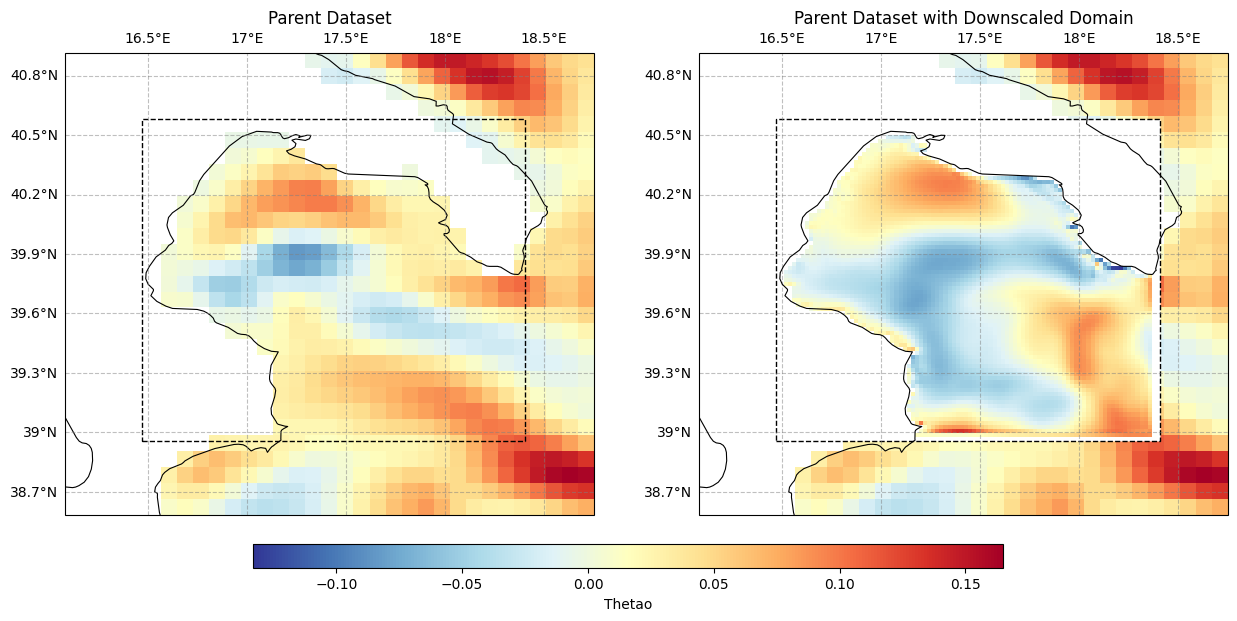

In [28]:
import logging
import os
import numpy as np
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from cartopy.io import DownloadWarning
from matplotlib.patches import Rectangle

# Suppress warnings (optional)
warnings.filterwarnings("ignore", category=DownloadWarning)

# Dataset parameters
datasets = {
    'downscaled': {
        'src_path': "/Users/lgiunti/Work/Tests/test-surf-nemo/gulfTaranto_20141005_DEMONSTRATOR/nest_0/simulation/2014-10-06T00-00-00_2014-10-07T00-00-00",
        'src_filename': "output_fields_grid_U.nc",
        'mask_path': "/Users/lgiunti/Work/Tests/test-surf-nemo/gulfTaranto_20141005_DEMONSTRATOR/nest_0/preprocessing/meshing/mesh/output/",
        'mask_filename': "mesh_mask.nc",
        'mask_var_name': "umask",
        'var_name': "uo",
        'lat_coord_name': "nav_lat",
        'lon_coord_name': "nav_lon",
    },
    'parent': {
        'src_path': "/Users/lgiunti/Work/Tests/test-surf-nemo/gulfTaranto_20141005_DEMONSTRATOR/nest_0/preprocessing/ocean_obc/reformat/",
        'src_filename': "velu_y2014m10d06.nc",
        'mask_path': "/Users/lgiunti/Work/Tests/test-surf-nemo/gulfTaranto_20141005_DEMONSTRATOR/nest_0/preprocessing/ocean_obc/reformat/",
        'mask_filename': "mask_ocean_T.nc",
        'mask_var_name': "tmask",
        'var_name': "uo",
        'lat_coord_name': "nav_lat",
        'lon_coord_name': "nav_lon",
    },
}

# General parameters
dst_path = "."
t_slice = ""
z_slice = ""
export_to_pdf = False
figsize = (15, 8)
enable_contour_plot = True

# Set defaults
imshow_kwargs = {"cmap": "RdYlBu_r", "origin": "lower"}
contour_kwargs = {"cmap": "RdYlBu_r", "nlevels": 15}
colorbar_kwargs = {"orientation": "vertical", "pad": 0.025}
coastline_kwargs = {"linewidth": 0.8, "color": "k"}
gridlines_kwargs = {"draw_labels": True, "color": "gray", "alpha": 0.5, "linestyle": "--"}

def read_and_process_dataset(params, t_slice="", z_slice=""):
    ds = xr.open_dataset(os.path.join(params['src_path'], params['src_filename']))
    ds_mask = xr.open_dataset(os.path.join(params['mask_path'], params['mask_filename']))

    lon = ds[params['lon_coord_name']].values
    lat = ds[params['lat_coord_name']].values

    # Handle 'zos' variable if needed
    if params['var_name'] == "zos":
        ds[params['var_name']] = ds[params['var_name']].expand_dims("z", 1)
        z_slice = "0-1"

    shape = ds[params['var_name']].shape
    t_slice = t_slice.split("-") if t_slice != "" else [0, shape[0]]
    z_slice = z_slice.split("-") if z_slice != "" else [0, shape[1]]

    t = int(t_slice[0])
    z = int(z_slice[0])

    # Get data and mask
    data = ds[params['var_name']][t, z, ...].values
    mask = ds_mask[params['mask_var_name']][0, z, ...].values
    data_masked = xr.where(mask == 0, np.nan, data)

    # Ensure lon and lat are 2D if needed
    if lon.ndim == 1 and lat.ndim == 1:
        lon2d, lat2d = np.meshgrid(lon, lat)
    else:
        lon2d = lon
        lat2d = lat

    return lon2d, lat2d, data_masked

# Read and process datasets
lon_downscaled, lat_downscaled, data_masked_downscaled = read_and_process_dataset(datasets['downscaled'], t_slice, z_slice)
lon_parent, lat_parent, data_masked_parent = read_and_process_dataset(datasets['parent'], t_slice, z_slice)

# Determine the common color scale
vmin = np.nanmin([np.nanmin(data_masked_downscaled), np.nanmin(data_masked_parent)])
vmax = np.nanmax([np.nanmax(data_masked_downscaled), np.nanmax(data_masked_parent)])

# Create figure and subplots using plt.subplots
fig, (ax_parent, ax_combined) = plt.subplots(nrows=1, ncols=2, figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})

# Parent dataset: Left subplot (ax_parent)
extent_parent = [lon_parent.min(), lon_parent.max(), lat_parent.min(), lat_parent.max()]
ax_parent.set_extent(extent_parent, crs=ccrs.PlateCarree())

# Plot parent dataset on ax_parent
im_parent = ax_parent.imshow(data_masked_parent, extent=extent_parent, vmin=vmin, vmax=vmax, **imshow_kwargs)
ax_parent.coastlines(**coastline_kwargs)
gl_parent = ax_parent.gridlines(crs=ccrs.PlateCarree(), **gridlines_kwargs)
gl_parent.right_labels = False
gl_parent.bottom_labels = False

# Overlay downscaled extent as dashed rectangle on ax_parent
extent_downscaled = [lon_downscaled.min(), lon_downscaled.max(), lat_downscaled.min(), lat_downscaled.max()]
rect = Rectangle((extent_downscaled[0], extent_downscaled[2]),
                 extent_downscaled[1]-extent_downscaled[0],
                 extent_downscaled[3]-extent_downscaled[2],
                 linewidth=1, edgecolor='k', facecolor='none', linestyle='--', transform=ccrs.PlateCarree())
ax_parent.add_patch(rect)

# Combined plot: Right subplot (ax_combined)
ax_combined.set_extent(extent_parent, crs=ccrs.PlateCarree())

# Plot parent dataset on ax_combined
im_combined = ax_combined.imshow(data_masked_parent, zorder=0, extent=extent_parent, vmin=vmin, vmax=vmax, **imshow_kwargs)

# Add the dashed rectangle to ax_combined
rect2 = Rectangle((extent_downscaled[0], extent_downscaled[2]),
                  extent_downscaled[1]-extent_downscaled[0],
                  extent_downscaled[3]-extent_downscaled[2],
                  linewidth=1, edgecolor='k', zorder=1, facecolor='white', linestyle='--', transform=ccrs.PlateCarree())
ax_combined.add_patch(rect2)

# Overlay downscaled data onto ax_combined within the rectangle
ax_combined.imshow(data_masked_downscaled, zorder=2, extent=extent_downscaled, vmin=vmin, vmax=vmax, **imshow_kwargs)

ax_combined.coastlines(zorder=3, **coastline_kwargs)
gl_combined = ax_combined.gridlines(crs=ccrs.PlateCarree(), zorder=4, **gridlines_kwargs)
gl_combined.right_labels = False
gl_combined.bottom_labels = False

# Add titles
ax_parent.set_title("Parent Dataset")
ax_combined.set_title("Parent Dataset with Downscaled Domain")

# Add shared colorbar
cbar_ax = fig.add_axes([0.25, 0.14, 0.5, 0.03])  # Adjust position and size as needed
cbar = plt.colorbar(im_parent, cax=cbar_ax, orientation='horizontal')
cbar.set_label('VelU')



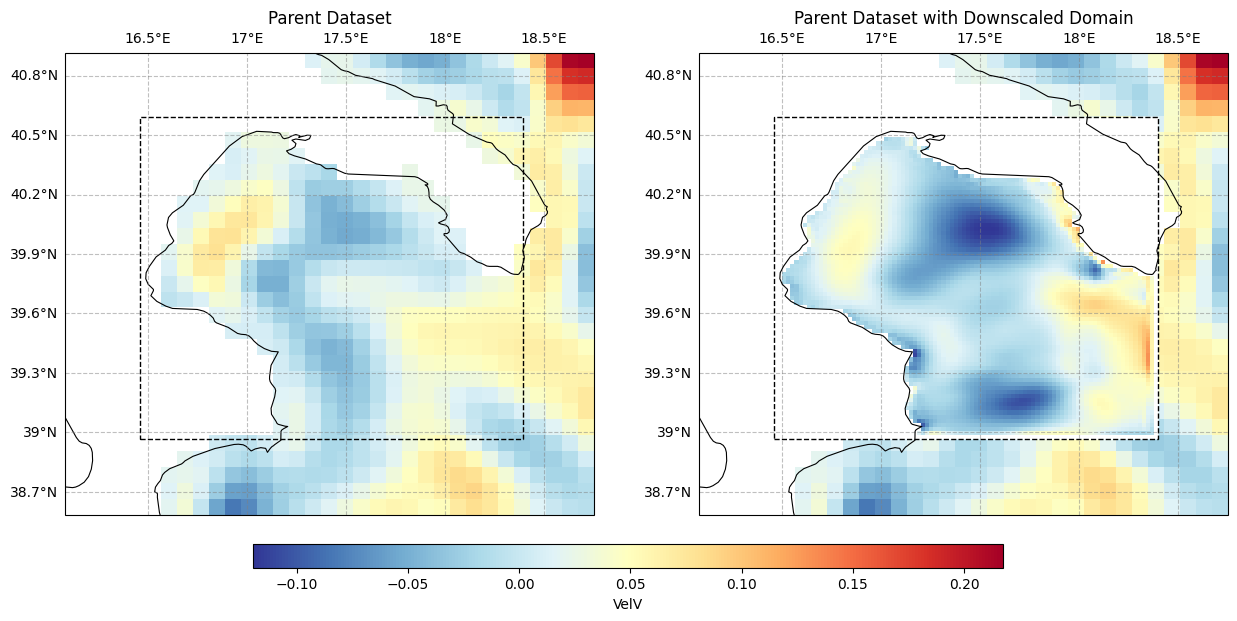

In [30]:
import logging
import os
import numpy as np
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from cartopy.io import DownloadWarning
from matplotlib.patches import Rectangle

# Suppress warnings (optional)
warnings.filterwarnings("ignore", category=DownloadWarning)

# Dataset parameters
datasets = {
    'downscaled': {
        'src_path': "/Users/lgiunti/Work/Tests/test-surf-nemo/gulfTaranto_20141005_DEMONSTRATOR/nest_0/simulation/2014-10-06T00-00-00_2014-10-07T00-00-00",
        'src_filename': "output_fields_grid_V.nc",
        'mask_path': "/Users/lgiunti/Work/Tests/test-surf-nemo/gulfTaranto_20141005_DEMONSTRATOR/nest_0/preprocessing/meshing/mesh/output/",
        'mask_filename': "mesh_mask.nc",
        'mask_var_name': "vmask",
        'var_name': "vo",
        'lat_coord_name': "nav_lat",
        'lon_coord_name': "nav_lon",
    },
    'parent': {
        'src_path': "/Users/lgiunti/Work/Tests/test-surf-nemo/gulfTaranto_20141005_DEMONSTRATOR/nest_0/preprocessing/ocean_obc/reformat/",
        'src_filename': "velv_y2014m10d06.nc",
        'mask_path': "/Users/lgiunti/Work/Tests/test-surf-nemo/gulfTaranto_20141005_DEMONSTRATOR/nest_0/preprocessing/ocean_obc/reformat/",
        'mask_filename': "mask_ocean_T.nc",
        'mask_var_name': "tmask",
        'var_name': "vo",
        'lat_coord_name': "nav_lat",
        'lon_coord_name': "nav_lon",
    },
}

# General parameters
dst_path = "."
t_slice = ""
z_slice = ""
export_to_pdf = False
figsize = (15, 8)
enable_contour_plot = True

# Set defaults
imshow_kwargs = {"cmap": "RdYlBu_r", "origin": "lower"}
contour_kwargs = {"cmap": "RdYlBu_r", "nlevels": 15}
colorbar_kwargs = {"orientation": "vertical", "pad": 0.025}
coastline_kwargs = {"linewidth": 0.8, "color": "k"}
gridlines_kwargs = {"draw_labels": True, "color": "gray", "alpha": 0.5, "linestyle": "--"}

def read_and_process_dataset(params, t_slice="", z_slice=""):
    ds = xr.open_dataset(os.path.join(params['src_path'], params['src_filename']))
    ds_mask = xr.open_dataset(os.path.join(params['mask_path'], params['mask_filename']))

    lon = ds[params['lon_coord_name']].values
    lat = ds[params['lat_coord_name']].values

    # Handle 'zos' variable if needed
    if params['var_name'] == "zos":
        ds[params['var_name']] = ds[params['var_name']].expand_dims("z", 1)
        z_slice = "0-1"

    shape = ds[params['var_name']].shape
    t_slice = t_slice.split("-") if t_slice != "" else [0, shape[0]]
    z_slice = z_slice.split("-") if z_slice != "" else [0, shape[1]]

    t = int(t_slice[0])
    z = int(z_slice[0])

    # Get data and mask
    data = ds[params['var_name']][t, z, ...].values
    mask = ds_mask[params['mask_var_name']][0, z, ...].values
    data_masked = xr.where(mask == 0, np.nan, data)

    # Ensure lon and lat are 2D if needed
    if lon.ndim == 1 and lat.ndim == 1:
        lon2d, lat2d = np.meshgrid(lon, lat)
    else:
        lon2d = lon
        lat2d = lat

    return lon2d, lat2d, data_masked

# Read and process datasets
lon_downscaled, lat_downscaled, data_masked_downscaled = read_and_process_dataset(datasets['downscaled'], t_slice, z_slice)
lon_parent, lat_parent, data_masked_parent = read_and_process_dataset(datasets['parent'], t_slice, z_slice)

# Determine the common color scale
vmin = np.nanmin([np.nanmin(data_masked_downscaled), np.nanmin(data_masked_parent)])
vmax = np.nanmax([np.nanmax(data_masked_downscaled), np.nanmax(data_masked_parent)])

# Create figure and subplots using plt.subplots
fig, (ax_parent, ax_combined) = plt.subplots(nrows=1, ncols=2, figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})

# Parent dataset: Left subplot (ax_parent)
extent_parent = [lon_parent.min(), lon_parent.max(), lat_parent.min(), lat_parent.max()]
ax_parent.set_extent(extent_parent, crs=ccrs.PlateCarree())

# Plot parent dataset on ax_parent
im_parent = ax_parent.imshow(data_masked_parent, extent=extent_parent, vmin=vmin, vmax=vmax, **imshow_kwargs)
ax_parent.coastlines(**coastline_kwargs)
gl_parent = ax_parent.gridlines(crs=ccrs.PlateCarree(), **gridlines_kwargs)
gl_parent.right_labels = False
gl_parent.bottom_labels = False

# Overlay downscaled extent as dashed rectangle on ax_parent
extent_downscaled = [lon_downscaled.min(), lon_downscaled.max(), lat_downscaled.min(), lat_downscaled.max()]
rect = Rectangle((extent_downscaled[0], extent_downscaled[2]),
                 extent_downscaled[1]-extent_downscaled[0],
                 extent_downscaled[3]-extent_downscaled[2],
                 linewidth=1, edgecolor='k', facecolor='none', linestyle='--', transform=ccrs.PlateCarree())
ax_parent.add_patch(rect)

# Combined plot: Right subplot (ax_combined)
ax_combined.set_extent(extent_parent, crs=ccrs.PlateCarree())

# Plot parent dataset on ax_combined
im_combined = ax_combined.imshow(data_masked_parent, zorder=0, extent=extent_parent, vmin=vmin, vmax=vmax, **imshow_kwargs)

# Add the dashed rectangle to ax_combined
rect2 = Rectangle((extent_downscaled[0], extent_downscaled[2]),
                  extent_downscaled[1]-extent_downscaled[0],
                  extent_downscaled[3]-extent_downscaled[2],
                  linewidth=1, edgecolor='k', zorder=1, facecolor='white', linestyle='--', transform=ccrs.PlateCarree())
ax_combined.add_patch(rect2)

# Overlay downscaled data onto ax_combined within the rectangle
ax_combined.imshow(data_masked_downscaled, zorder=2, extent=extent_downscaled, vmin=vmin, vmax=vmax, **imshow_kwargs)

ax_combined.coastlines(zorder=3, **coastline_kwargs)
gl_combined = ax_combined.gridlines(crs=ccrs.PlateCarree(), zorder=4, **gridlines_kwargs)
gl_combined.right_labels = False
gl_combined.bottom_labels = False

# Add titles
ax_parent.set_title("Parent Dataset")
ax_combined.set_title("Parent Dataset with Downscaled Domain")

# Add shared colorbar
cbar_ax = fig.add_axes([0.25, 0.14, 0.5, 0.03])  # Adjust position and size as needed
cbar = plt.colorbar(im_parent, cax=cbar_ax, orientation='horizontal')
cbar.set_label('VelV')

